# **CSE641: *Deep Learing Assignment-1***

In [99]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
import os
import gzip
import time
import random
import idx2numpy
import numpy as np
import urllib.request
from PIL import Image
from typing import Callable
from matplotlib import pyplot as plt

## **Question: 1**

For Question-1, we implement the `pytorch.utils.data.Dataset` and `pytorch.utils.data.DataLoader` classes from scratch in Python. Specifically, we make use of the `MNIST` dataset, hence the `torchvision.datasets.MNIST`. Using the template provided, we implement the classes `MNISTDataset` and `MyDataLoader`. Finally, the performance of the scratch implementation is compared with the `torch` implementations by plotting a graph of batch-size vs total data loading time.

### **References**

1. [`torch.utils.data.DataLoader`, `torch.utils.data.Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
2. [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html#MNIST)

In [3]:
class MNISTDataset:
	ULRLs: tuple[str] = (
		r"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
		r"http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
		r"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
		r"http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
	)

	def __init__(self, root: str, train: bool|None = False, download: bool|None = False, transform: Callable|None = None, target_transform: Callable|None = None):
		self.root = os.path.join(root, "MNIST")
		self.train = train
		if download and not os.path.exists(self.root):
			self.download()
		self.transform = transform
		self.target_transform = target_transform
		self._load()

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx: int) -> tuple[_, int]:
		image, target = Image.fromarray(self.data[idx]), int(self.targets[idx])
		if self.transform is not None:
			image = self.transform(image)
		if self.target_transform is not None:
			target = self.target_transform(target)
		return image, target

	def download(self) -> None:
		directory = os.path.join(self.root, "raw")
		os.makedirs(directory, exist_ok=True)
		for url in MNISTDataset.URLs:
			filename = os.path.join(directory, os.path.basename(url))
			destination = filename.replace(".gz", "")
			urllib.request.urlretrieve(url, filename)
			with gzip.open(filename, "rb") as f_in:
				with open(destination, "wb") as f_out:
					f_out.write(f_in.read())

	def _load(self) -> None:
		prefix = "train" if self.train else "t10k"
		images_filename = os.path.join(self.root, "raw", f"{prefix}-images-idx3-ubyte")
		labels_filename = os.path.join(self.root, "raw", f"{prefix}-labels-idx1-ubyte")
		self.data = idx2numpy.convert_from_file(images_filename)
		self.targets = torch.tensor(idx2numpy.convert_from_file(labels_filename), dtype=torch.int64)

In [4]:
class MyDataLoader:
    def __init__(self, dataset: MNISTDataset|Dataset, batch_size: int|None = 1, shuffle: bool|None = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset_size = len(dataset)
        self.indices = torch.arange(self.dataset_size)

    def __len__(self) -> int:
        return (self.dataset_size + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)
        self.current_index = 0
        return self

    def __next__(self):
        if self.current_index >= self.dataset_size:
            raise StopIteration
        batch_indices = self.indices[self.current_index:self.current_index+self.batch_size]
        data_batch = torch.stack([self.dataset[i][0] for i in batch_indices])
        target_batch = self.dataset.targets[batch_indices]
        self.current_index += self.batch_size
        return data_batch, target_batch

In [5]:
py_training_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
my_training_data = MNISTDataset(root="data", train=True, download=True, transform=transforms.ToTensor())

In [6]:
times = torch.zeros(2, 5)
REPEATS = 10

# times = torch.load("average_times.pt")
# print("Loaded average times")
# print(times)

# for i in range(5):
#     batch_size = 2 ** (i+6)
#     py_train_dataloader = DataLoader(py_training_data, batch_size=batch_size, shuffle=False)
#     my_train_dataloader = MyDataLoader(my_training_data, batch_size=batch_size, shuffle=False)

#     for j in range(REPEATS):
#         print(f"Batch size: {batch_size}, repeat: {j}", end="\r")

#         start = time.time()
#         for data, target in py_train_dataloader: pass
#         times[0, i] += time.time() - start

#         start = time.time()
#         for data, target in my_train_dataloader: pass
#         times[1, i] += time.time() - start

# print(times := times/(REPEATS*5))
# torch.save(times, "average_times.pt")

Loaded average times
tensor([[1.0491, 1.0244, 1.0719, 1.0259, 1.0685],
        [0.9706, 0.9418, 1.0100, 0.9717, 0.9981]])


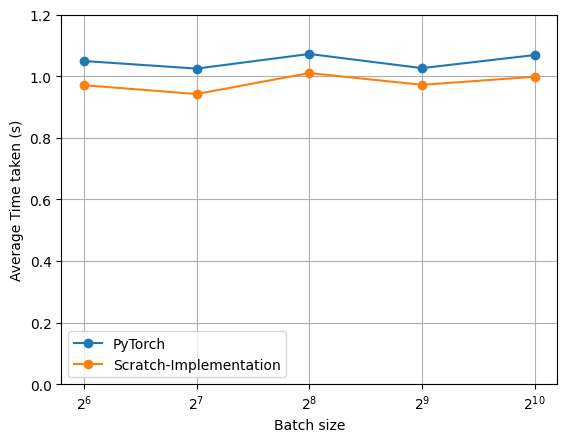

In [7]:
plt.plot([2**(i+6) for i in range(5)], times[0], label="PyTorch", marker="o")
plt.plot([2**(i+6) for i in range(5)], times[1], label="Scratch-Implementation", marker="o")

plt.xlabel("Batch size")
plt.ylabel("Average Time taken (s)")
plt.legend()

plt.xscale("log", base=2)
plt.ylim(0, 1.2)
plt.grid(True)
plt.show()

## **Question: 2**

In this question, we implement a simple Feed-Forward Neural Netowrk using Pytorch with the following specifications:
- 4 Hidden Layers
- At least 32 Nodes in each Hidden Layer
- Load the data using the more effective dataloader as identified in Question-1
- Activation Function: [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Loss Function: [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- Optimizer: [`torch.optim.SGD` (Stochastic Gradient Descent)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- Learning Rate: 0.0003

Finally, we plot graphs of the loss and accuracy vs number of epochs for training, testing, and validation data for 60 epochs.

### **References**

1. [PyTorch Crash Course - Getting Started with Deep Learning, YouTube](https://www.youtube.com/watch?v=OIenNRt2bjg)
2. [PyTorch Official Documentation](https://pytorch.org/docs/stable/index.html)

### **Observations**

1. Even with 4 hidden layers of 128 neurons each, the model achieves a menial accuracy of 12%.
2. The learning rate 0.0003 seems to be too small for the model, and the model often gets stuck in some local minima - achieving no improvement in loss or accuracy via updates.
3. With a higher learning rate of 0.003, the loss of the model decreases significantly, but the accuracy remains in the same range. This is probably due to overfitting - we can reduce the number of hidden layers and number of epochs for a better generalization.

In [59]:
class FeedForward(nn.Module):
    def __init__(self, input_size: int, hidden_size: list[int], output_size: int):
        super(FeedForward, self).__init__()
        self.relu = nn.ReLU()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_size[0])])
        for i in range(len(hidden_size)-1):
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
        self.layers.append(nn.Linear(hidden_size[-1], output_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = x
        for layer in self.layers:
            out = self.relu(layer(out))
        return out

In [150]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 28 * 28
hidden_size = [128, 128, 128, 128]
output_size = 10
epochs = 60
batch_size = 256
learning_rate = 0.0003

train_data = MNISTDataset(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = MNISTDataset(root="data", train=False, download=True, transform=transforms.ToTensor())

train_loader = MyDataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = MyDataLoader(test_data, batch_size=batch_size, shuffle=False)

In [151]:
TRAIN_X, TRAIN_y = next(iter(DataLoader(train_data, batch_size=len(train_data), shuffle=True)))
TEST_X, TEST_y = next(iter(DataLoader(test_data, batch_size=len(test_data), shuffle=False)))
TEST_X, VAL_X, TEST_y, VAL_y = train_test_split(TEST_X, TEST_y, test_size=0.2, shuffle=True, random_state=42)

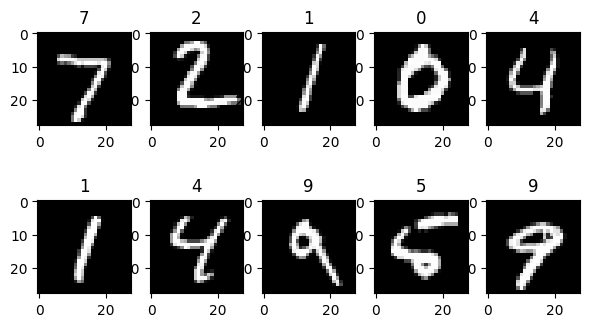

In [175]:
# SANITY CHECK
examples = iter(test_loader)
example_data, example_targets = next(examples)

plt.figure(figsize=(7, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(example_targets[i].item())
plt.show()

In [153]:
model = FeedForward(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [154]:
ACCURACY = torch.zeros(3, 60)
LOSS = torch.zeros(3, 60)

steps = len(train_loader)
for epoch in range(1, epochs+1):
    for batch, (images, labels) in enumerate(train_loader, start=1):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            print(f"Epoch [{str(epoch).zfill(2)}/{epochs}], Batch [{str(batch).zfill(3)}/{steps}], Loss: {loss:.10f}", end="\r")

    with torch.no_grad():
        model.eval()
        train_pred = model(TRAIN_X.reshape(-1, 28*28).to(device)).cpu()
        test_pred = model(TEST_X.reshape(-1, 28*28).to(device)).cpu()
        val_pred = model(VAL_X.reshape(-1, 28*28).to(device)).cpu()

        ACCURACY[0, epoch-1] = accuracy_score(TRAIN_y, train_pred.argmax(dim=1).cpu())
        ACCURACY[1, epoch-1] = accuracy_score(TEST_y, test_pred.argmax(dim=1).cpu())
        ACCURACY[2, epoch-1] = accuracy_score(VAL_y, val_pred.argmax(dim=1).cpu())

        LOSS[0, epoch-1] = criterion(train_pred, TRAIN_y)
        LOSS[1, epoch-1] = criterion(test_pred, TEST_y)
        LOSS[2, epoch-1] = criterion(val_pred, VAL_y)

        model.train()

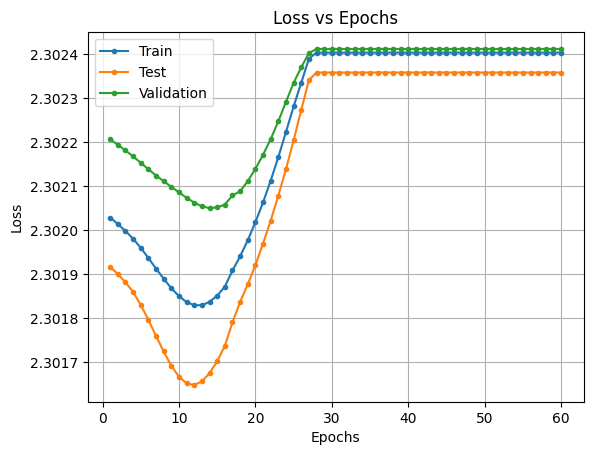

In [173]:
plt.plot(range(1, epochs+1), LOSS[0], label="Train", marker=".")
plt.plot(range(1, epochs+1), LOSS[1], label="Test", marker=".")
plt.plot(range(1, epochs+1), LOSS[2], label="Validation", marker=".")

plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

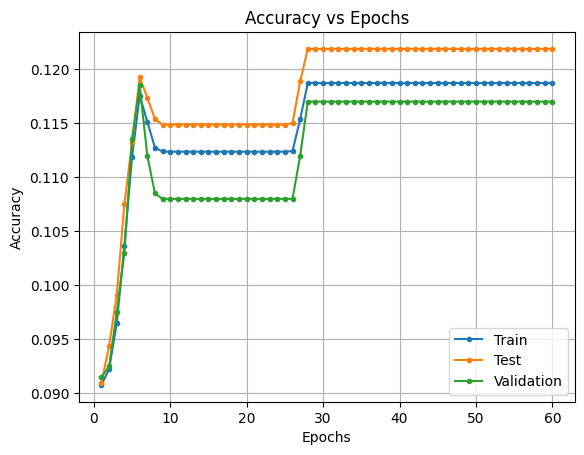

In [172]:
plt.plot(range(1, epochs+1), ACCURACY[0], label="Train", marker=".")
plt.plot(range(1, epochs+1), ACCURACY[1], label="Test", marker=".")
plt.plot(range(1, epochs+1), ACCURACY[2], label="Validation", marker=".")

plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## **Question: 3**